# Text Classification - Sentiment Analysis - NLP

Buatlah model Sentiment Analysis menggunakan traditional Machine Learning algorithm dengan feature berupa bag of words. Gunakan data pada repository: https://github.com/IndoNLP/indonlu/tree/master/dataset/smsa_doc-sentiment-prosa 

Lakukan eksperimen untuk variasi feature extraction yang telah diajarkan di kelas yaitu bag of words dengan traditional ML algorithm (minimal 3 algoritme). Tetapkan preprocessing apa yang digunakan.

In [352]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import re

In [353]:
data_train_preprocess =  pd.read_csv('data/train_preprocess.tsv', sep='\t', header=None, names=['text', 'label'])
data_test_preprocess = pd.read_csv('data/test_preprocess.tsv', sep='\t', header=None, names=['text', 'label'])
data_test_preprocess_masked_label = pd.read_csv('data/test_preprocess_masked_label.tsv', sep='\t', header=None, names=['text', 'label'])
data_valid_preprocess = pd.read_csv('data/valid_preprocess.tsv', sep='\t', header=None, names=['text', 'label'])

X_train = data_train_preprocess['text']
y_train = data_train_preprocess['label']

X_test = data_test_preprocess['text']
y_test = data_test_preprocess['label']

X_test_masked_label = data_test_preprocess_masked_label['text']
y_test_masked_label = data_test_preprocess_masked_label['label']

X_valid = data_valid_preprocess['text']
y_valid = data_valid_preprocess['label']

## Data Analysis

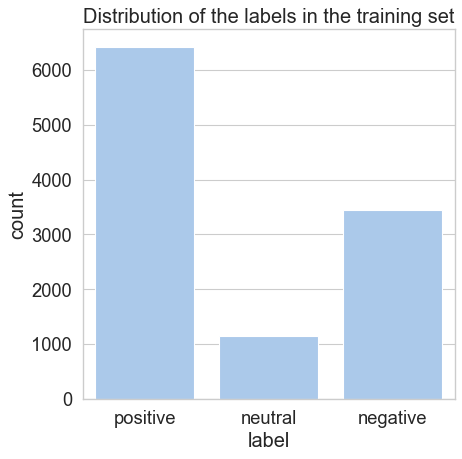

In [354]:
# data analysis

# Graph of the distribution of the labels
def plot_distribution(y, title):
    sns.set_palette('pastel')
    plt.figure(figsize=(6, 6), dpi=80)
    sns.countplot(x=y)
    plt.title(title)
    plt.show()
    
plot_distribution(y_train, 'Distribution of the labels in the training set')

In [355]:
# solve the problem of class imbalance with RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_train_oversample, y_train_oversample = ros.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train))

# Graph of the distribution of the labels after solving the problem of class imbalance
y_train_oversample = y_train_oversample["label"]
X_train_oversample = X_train_oversample["text"]

In [356]:
# solve the problem of class imbalance with undersampling

rus = RandomUnderSampler(random_state=0)
X_train_undersample, y_train_undersample = rus.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train))

# Graph of the distribution of the labels after solving the problem of class imbalance
y_train_undersample = y_train_undersample["label"]
X_train_undersample = X_train_undersample["text"]

## Preprocessing

In [421]:
def preprocess_text(text: str) -> str:
    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    # entity masking
    # url masking
    text = re.sub(r'http\S+', 'url', text)
    # email masking
    text = re.sub(r'\S+@\S+', 'email', text)
    # phone number masking 9 digits or more, with or without space, with - or without
    text = re.sub(r'(\d{9,}|\d{3,}[-\s]\d{3,}[-\s]\d{3,})', 'phone_number', text)
    return text

X_train_oversample = X_train_oversample.apply(lambda x: preprocess_text(x))
X_train_undersample = X_train_undersample.apply(lambda x: preprocess_text(x))
X_train_normal = X_train.apply(lambda x: preprocess_text(x))

X_test = X_test.apply(lambda x: preprocess_text(x))
X_test_masked_label = X_test_masked_label.apply(lambda x: preprocess_text(x))
X_valid = X_valid.apply(lambda x: preprocess_text(x))

In [422]:
# Initialize vectorizer globally so the same one can be used for both train and test

# Function to fit on training data and transform to bag of words
def bag_of_words(texts_train: pd.Series, texts_test: pd.Series) -> np.ndarray:
    vectorizer = CountVectorizer(max_features=1000)
    X_train = vectorizer.fit_transform(texts_train).toarray()
    X_test = vectorizer.transform(texts_test).toarray()
    return X_train, X_test

In [423]:
# Encoding the labels
y_train_oversample = LabelEncoder().fit_transform(y_train_oversample)
y_train_undersample = LabelEncoder().fit_transform(y_train_undersample)
y_train_normal = LabelEncoder().fit_transform(y_train)

y_test = LabelEncoder().fit_transform(y_test)
y_test_masked_label = LabelEncoder().fit_transform(y_test_masked_label)
y_valid = LabelEncoder().fit_transform(y_valid)

# display the label encoding and its corresponding class
label_mapping = dict(zip(LabelEncoder().fit(y_train).transform(LabelEncoder().fit(y_train).classes_), LabelEncoder().fit(y_train).classes_))
print(label_mapping)

{0: 'negative', 1: 'neutral', 2: 'positive'}


## Model

### Logistic Regression 

In [386]:
# Model training
# Logistic Regression
def logistic_regression(X_train, y_train, X_test, y_test):
    X_train, X_test = bag_of_words(X_train, X_test)
    # Model training
    logistic_regression = LogisticRegression(max_iter=1000)
    logistic_regression.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = logistic_regression.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return logistic_regression

In [387]:
# Logistic Regression
print('Logistic Regression')
print('normal')
logistic_regression(X_train_normal, y_train_normal, X_test, y_test)
print('undersample')
logistic_regression(X_train_undersample, y_train_undersample, X_test, y_test)
print('oversample')
logrec = logistic_regression(X_train_oversample, y_train_oversample, X_test, y_test)

Logistic Regression
normal
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       204
           1       0.81      0.44      0.57        88
           2       0.82      0.78      0.80       208

    accuracy                           0.77       500
   macro avg       0.79      0.71      0.73       500
weighted avg       0.78      0.77      0.76       500

undersample
              precision    recall  f1-score   support

           0       0.65      0.91      0.76       204
           1       0.55      0.74      0.63        88
           2       0.89      0.41      0.56       208

    accuracy                           0.67       500
   macro avg       0.70      0.69      0.65       500
weighted avg       0.73      0.67      0.65       500

oversample
              precision    recall  f1-score   support

           0       0.73      0.92      0.81       204
           1       0.65      0.58      0.61        88
           2       0.87  

In [424]:
text = ['aku buruk sekali', 'saya sangat senang', 'sekolah adalah tempat belajar']
text = [preprocess_text(x) for x in text]
text = pd.Series(text)
vectorizer = CountVectorizer(max_features=1000)
y_predict = np.array([0, 2, 1])
logistic_regression(X_train_normal, y_train_normal, text, y_predict)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



LogisticRegression(max_iter=1000)

### Support Vector Machine (SVM)

In [362]:
# Model training
# Support Vector Machine
def support_vector_machine(X_train, y_train, X_test, y_test):
    X_train, X_test = bag_of_words(X_train, X_test)
    # Model training
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = svm.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return svm

In [363]:
# Support Vector Machine
print('Support Vector Machine')
print('normal')
support_vector_machine(X_train_normal, y_train_normal, X_test, y_test)
print('undersample')
support_vector_machine(X_train_undersample, y_train_undersample, X_test, y_test)
print('oversample')
svm = support_vector_machine(X_train_oversample, y_train_oversample, X_test, y_test)

Support Vector Machine
normal
              precision    recall  f1-score   support

           0       0.69      0.92      0.79       204
           1       0.74      0.44      0.55        88
           2       0.85      0.71      0.77       208

    accuracy                           0.75       500
   macro avg       0.76      0.69      0.71       500
weighted avg       0.76      0.75      0.74       500

undersample
              precision    recall  f1-score   support

           0       0.62      0.90      0.74       204
           1       0.54      0.66      0.59        88
           2       0.88      0.42      0.57       208

    accuracy                           0.66       500
   macro avg       0.68      0.66      0.63       500
weighted avg       0.71      0.66      0.64       500

oversample
              precision    recall  f1-score   support

           0       0.66      0.92      0.77       204
           1       0.67      0.49      0.57        88
           2       0.8

### Random Forest

In [364]:
# Model training
# Random Forest
def random_forest(X_train, y_train, X_test, y_test):
    X_train, X_test = bag_of_words(X_train, X_test)
    # Model training
    random_forest = RandomForestClassifier(n_estimators=100)
    random_forest.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = random_forest.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return random_forest

In [365]:
# Random Forest
print('Random Forest')
print('normal')
random_forest(X_train_normal, y_train_normal, X_test, y_test)
print('undersample')
random_forest(X_train_undersample, y_train_undersample, X_test, y_test)
print('oversample')
rf = random_forest(X_train_oversample, y_train_oversample, X_test, y_test)

Random Forest
normal
              precision    recall  f1-score   support

           0       0.59      0.91      0.72       204
           1       0.65      0.27      0.38        88
           2       0.81      0.58      0.68       208

    accuracy                           0.66       500
   macro avg       0.68      0.59      0.59       500
weighted avg       0.69      0.66      0.64       500

undersample
              precision    recall  f1-score   support

           0       0.56      0.94      0.70       204
           1       0.53      0.57      0.55        88
           2       0.84      0.25      0.39       208

    accuracy                           0.59       500
   macro avg       0.64      0.59      0.55       500
weighted avg       0.67      0.59      0.54       500

oversample
              precision    recall  f1-score   support

           0       0.58      0.93      0.71       204
           1       0.62      0.30      0.40        88
           2       0.81      0.

In [376]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Grid search to find the best parameters
text_clf = Pipeline([
    ('vect', CountVectorizer()), # Bag of words
    ('tfidf', TfidfTransformer()), # TF-IDF
    ('clf', SGDClassifier()), # Stochastic Gradient Descent
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
    'clf__penalty': ('l2', 'elasticnet'),
}

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [377]:
gs_clf = gs_clf.fit(X_train_normal, y_train_normal)
print(gs_clf.best_score_)

0.8314545454545454


In [378]:
gs_clf_under = gs_clf.fit(X_train_undersample, y_train_undersample)
print(gs_clf_under.best_score_)

0.840589664832754


In [379]:
gs_clf_over = gs_clf.fit(X_train_oversample, y_train_oversample)
print(gs_clf_over.best_score_)

0.9112132211773677


In [380]:
# result model
# print the best parameters
print(gs_clf_over.best_params_)

y_pred = gs_clf_over.predict(X_valid)
print(classification_report(y_valid, y_pred))

{'clf__alpha': 0.001, 'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (2, 2)}
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       394
           1       0.74      0.57      0.65       131
           2       0.87      0.91      0.89       735

    accuracy                           0.83      1260
   macro avg       0.79      0.75      0.77      1260
weighted avg       0.82      0.83      0.82      1260



In [381]:
y_pred = gs_clf_over.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.87      0.74       204
           1       0.53      0.42      0.47        88
           2       0.75      0.56      0.64       208

    accuracy                           0.66       500
   macro avg       0.64      0.62      0.62       500
weighted avg       0.67      0.66      0.65       500

